# Tutorial 2: Deep stimulus design with flyvis

## Learning objectives
In this tutorial, you will learn how to:
- **Load and work with pretrained neural network models** of the fly visual system.
- **Find optimal naturalistic stimuli** that maximally excite specific neurons.
- **Generate artificial optimal stimuli** using gradient-based optimization.
- **Compare different types of optimal stimuli** and their effects.

## Introduction

Understanding what makes a neuron respond strongly is fundamental to neuroscience. In this tutorial, we will explore how to find and generate stimuli that maximally excite specific neurons in computational models of the fly visual system.

We'll work with three types of optimal stimuli:
1. **Optimal naturalistic stimuli** - Finding the best stimulus from a dataset of natural scenes.
2. **Regularized optimal stimuli** - Simplifying naturalistic stimuli while preserving responses.
3. **Artificial optimal stimuli** - Generating stimuli from scratch using gradients.

## Setup

First, let's import the necessary libraries and set up our environment:

In [1]:
# No need to install flyvis, if you have already installed it in a previous tutorial
# !pip install "git+https://github.com/sjcabs/flyvis_tutorial.git"

In [2]:
# No need to download the pretrained model ensemble, if you have already downloaded it in a previous tutorial
# !flyvis download-pretrained

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# flyvis imports
from flyvis import NetworkView
from flyvis.datasets.sintel import AugmentedSintel
from flyvis.analysis.optimal_stimuli import (
    FindOptimalStimuli,
    GenerateOptimalStimuli,
    plot_stim_response,
)

# Set up plotting
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["font.size"] = 6
plt.rcParams["figure.dpi"] = 300

## Part 1: Loading data and models

Let's start by loading a dataset of naturalistic stimuli and a pretrained network model:

In [4]:
# Load the dataset of naturalistic stimuli (from the Sintel movie)
dataset = AugmentedSintel(tasks=["lum"], temporal_split=True)

# Load a pretrained network model from the ensemble
# The identifier "flow/0000/000" specifies: task/ensemble_id/network_id
# - "flow": the training task (optic flow prediction)
# - "0000": the first ensemble (collection of models trained with same configuration)
# - "000": the first network within that ensemble
network_view = NetworkView("flow/0000/000")

print(f"Dataset contains {len(dataset)} stimulus sequences")
print(f"Network model loaded successfully")

[2025-12-31 13:04:43] sintel_utils:331 Found Sintel at /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/SintelDataSet
[2025-12-31 13:04:48] network_view:122 Initialized network view at /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000


Dataset contains 2268 stimulus sequences
Network model loaded successfully


## Part 2: Finding optimal naturalistic stimuli

Let's find the stimulus from our dataset that maximally excites a T4c neuron. T4c neurons are direction-selective and should respond strongly to upward-moving ON edges.

In [5]:
# For the T4c neuron, we expect that the maximally excitatory stimulus
# should contain an ON-edge moving upward
target_cell_type = "T4c"
print(f"Finding optimal stimulus for {target_cell_type} neuron...")

Finding optimal stimulus for T4c neuron...


[2025-12-31 13:04:48] logging_utils:23 epe not in /groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000/validation, but 'loss' is. Falling back to 'loss'. You can rerun the ensemble validation to make appropriate recordings of the losses.


/groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_optimal_stimulus_responses/e751aa5a3767fb5d580f4a8fac2a783f/output.h5


Text(0.5, 0.8, 'Optimal Naturalistic Stimulus for T4c')

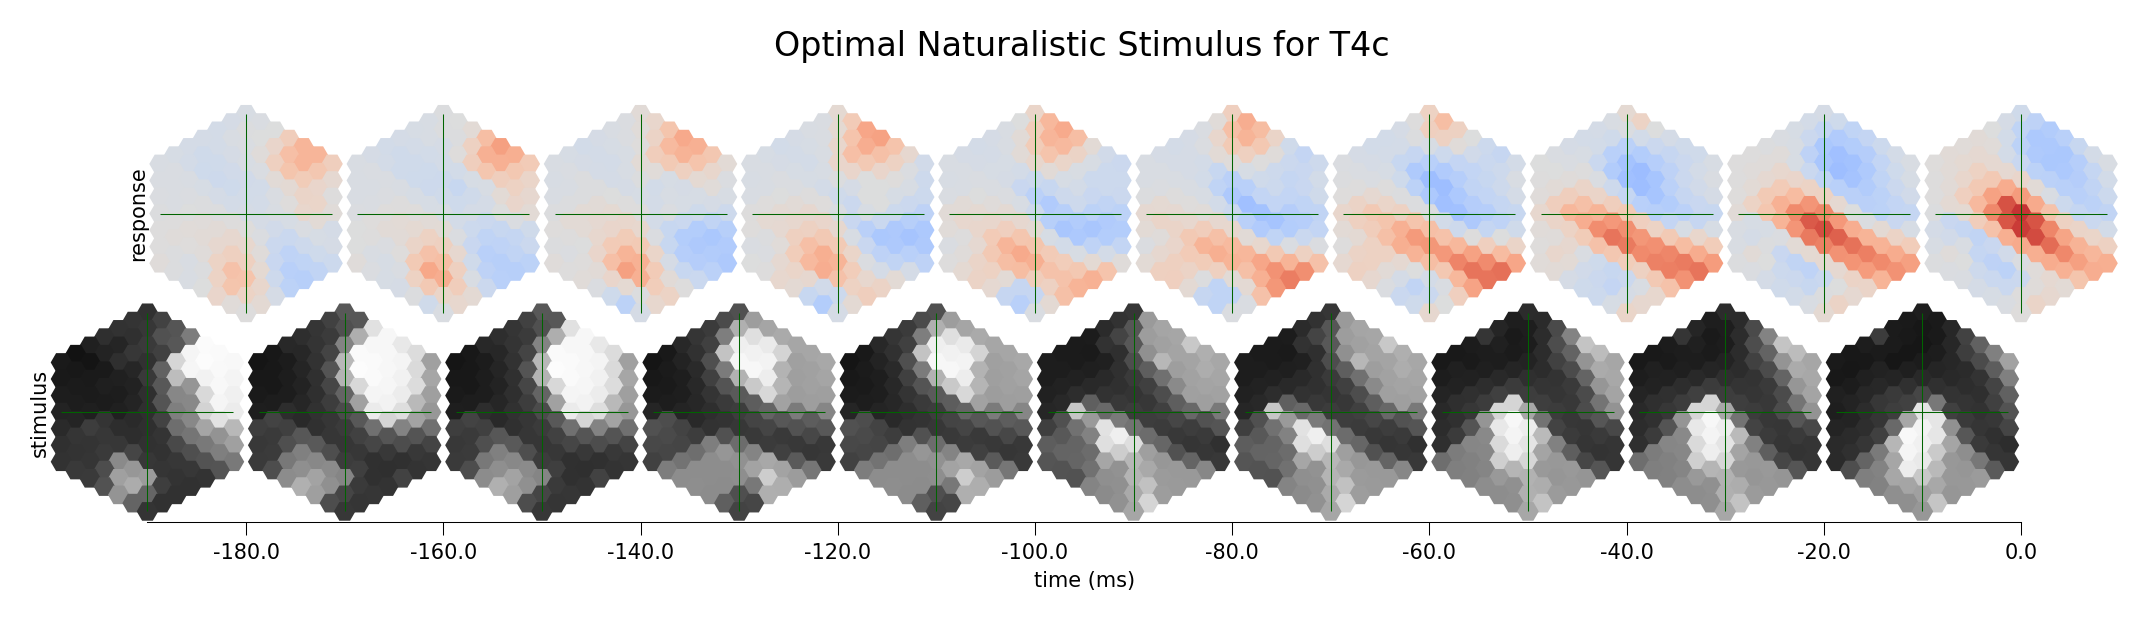

In [6]:
# Find the optimal stimulus responses
optstim = network_view.optimal_stimulus_responses(target_cell_type)

# Plot the optimal naturalistic stimulus and the response it evokes
stim_resp_plot = plot_stim_response(
    optstim.stimulus.stimulus,
    optstim.stimulus.response,
    1 / 100,  # dt = 1/100 seconds
    *network_view.connectome_view.get_uv(target_cell_type),
    figsize=[8, 3],
    label_peak_response=True,
)

plt.suptitle(f"Optimal Naturalistic Stimulus for {target_cell_type}", fontsize=8, y=0.8)

### 🤔 Discussion Questions

1. Does the optimal stimulus contain the expected ON-edge moving upward?
2. What other visual features do you notice in the stimulus?
3. When does the T4c neuron respond most strongly during the stimulus sequence?

## Part 3: Regularized optimal stimuli

The naturalistic stimulus contains many visual features. 

The previous function also computed a stimulus that maintains the same neural response but removes unnecessary details:

Text(0.5, 0.8, 'Regularized Optimal Stimulus for T4c')

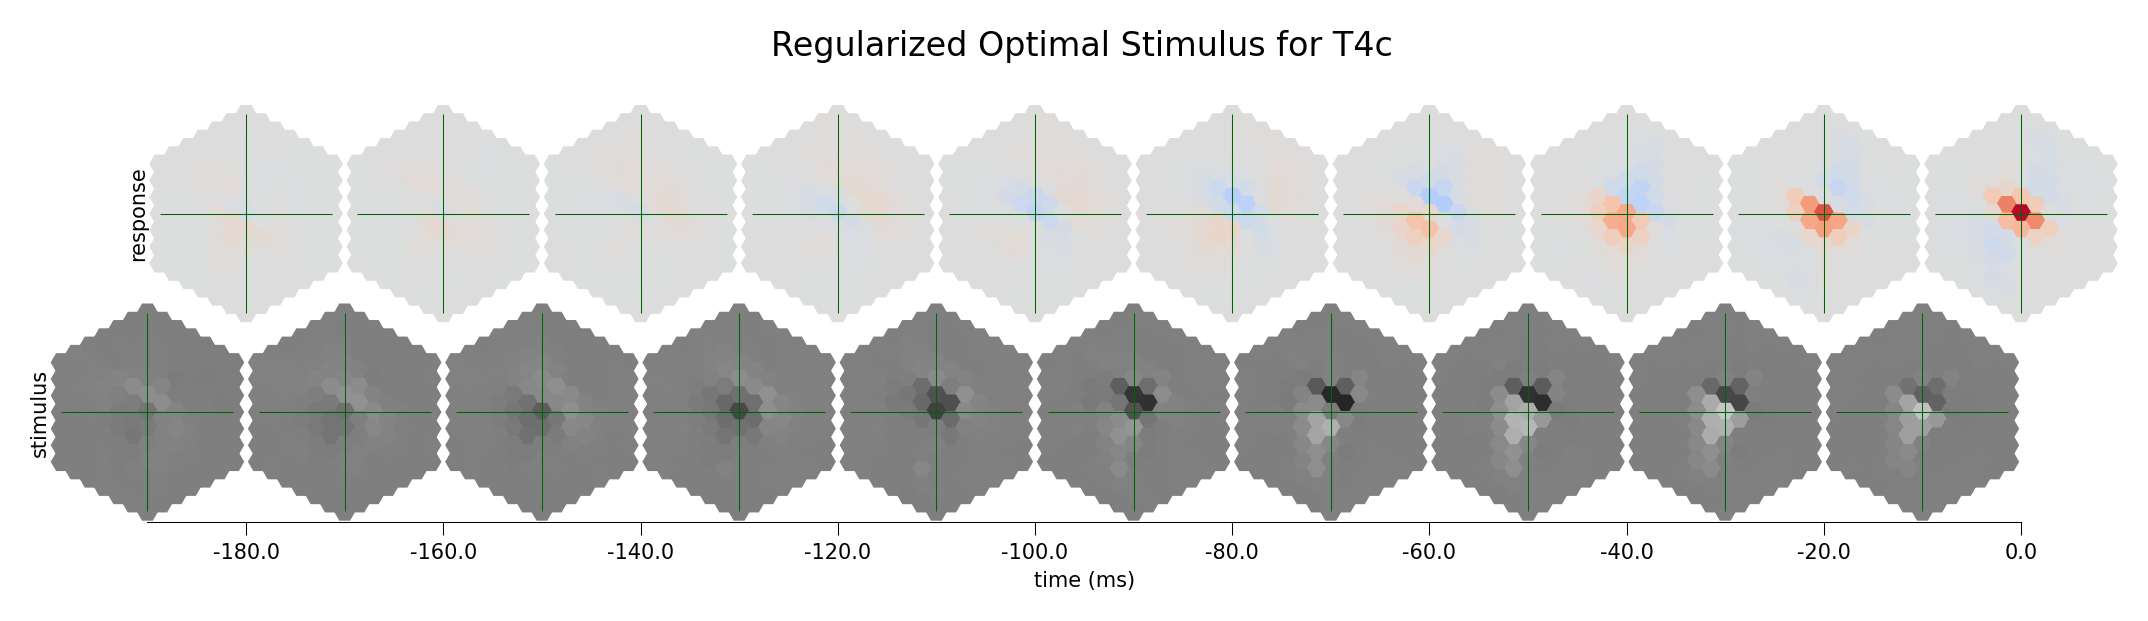

In [7]:
# Plot the regularized optimal stimulus
stim_resp_plot = plot_stim_response(
    optstim.regularized_stimulus,
    optstim.response,
    1 / 100,
    *network_view.connectome_view.get_uv(target_cell_type),
    figsize=[8, 3],
    label_peak_response=True,
)

plt.gcf().suptitle(
    f"Regularized Optimal Stimulus for {target_cell_type}", fontsize=8, y=0.8
)

### Comparing Responses

Let's verify that the regularized stimulus produces the same response as the original:

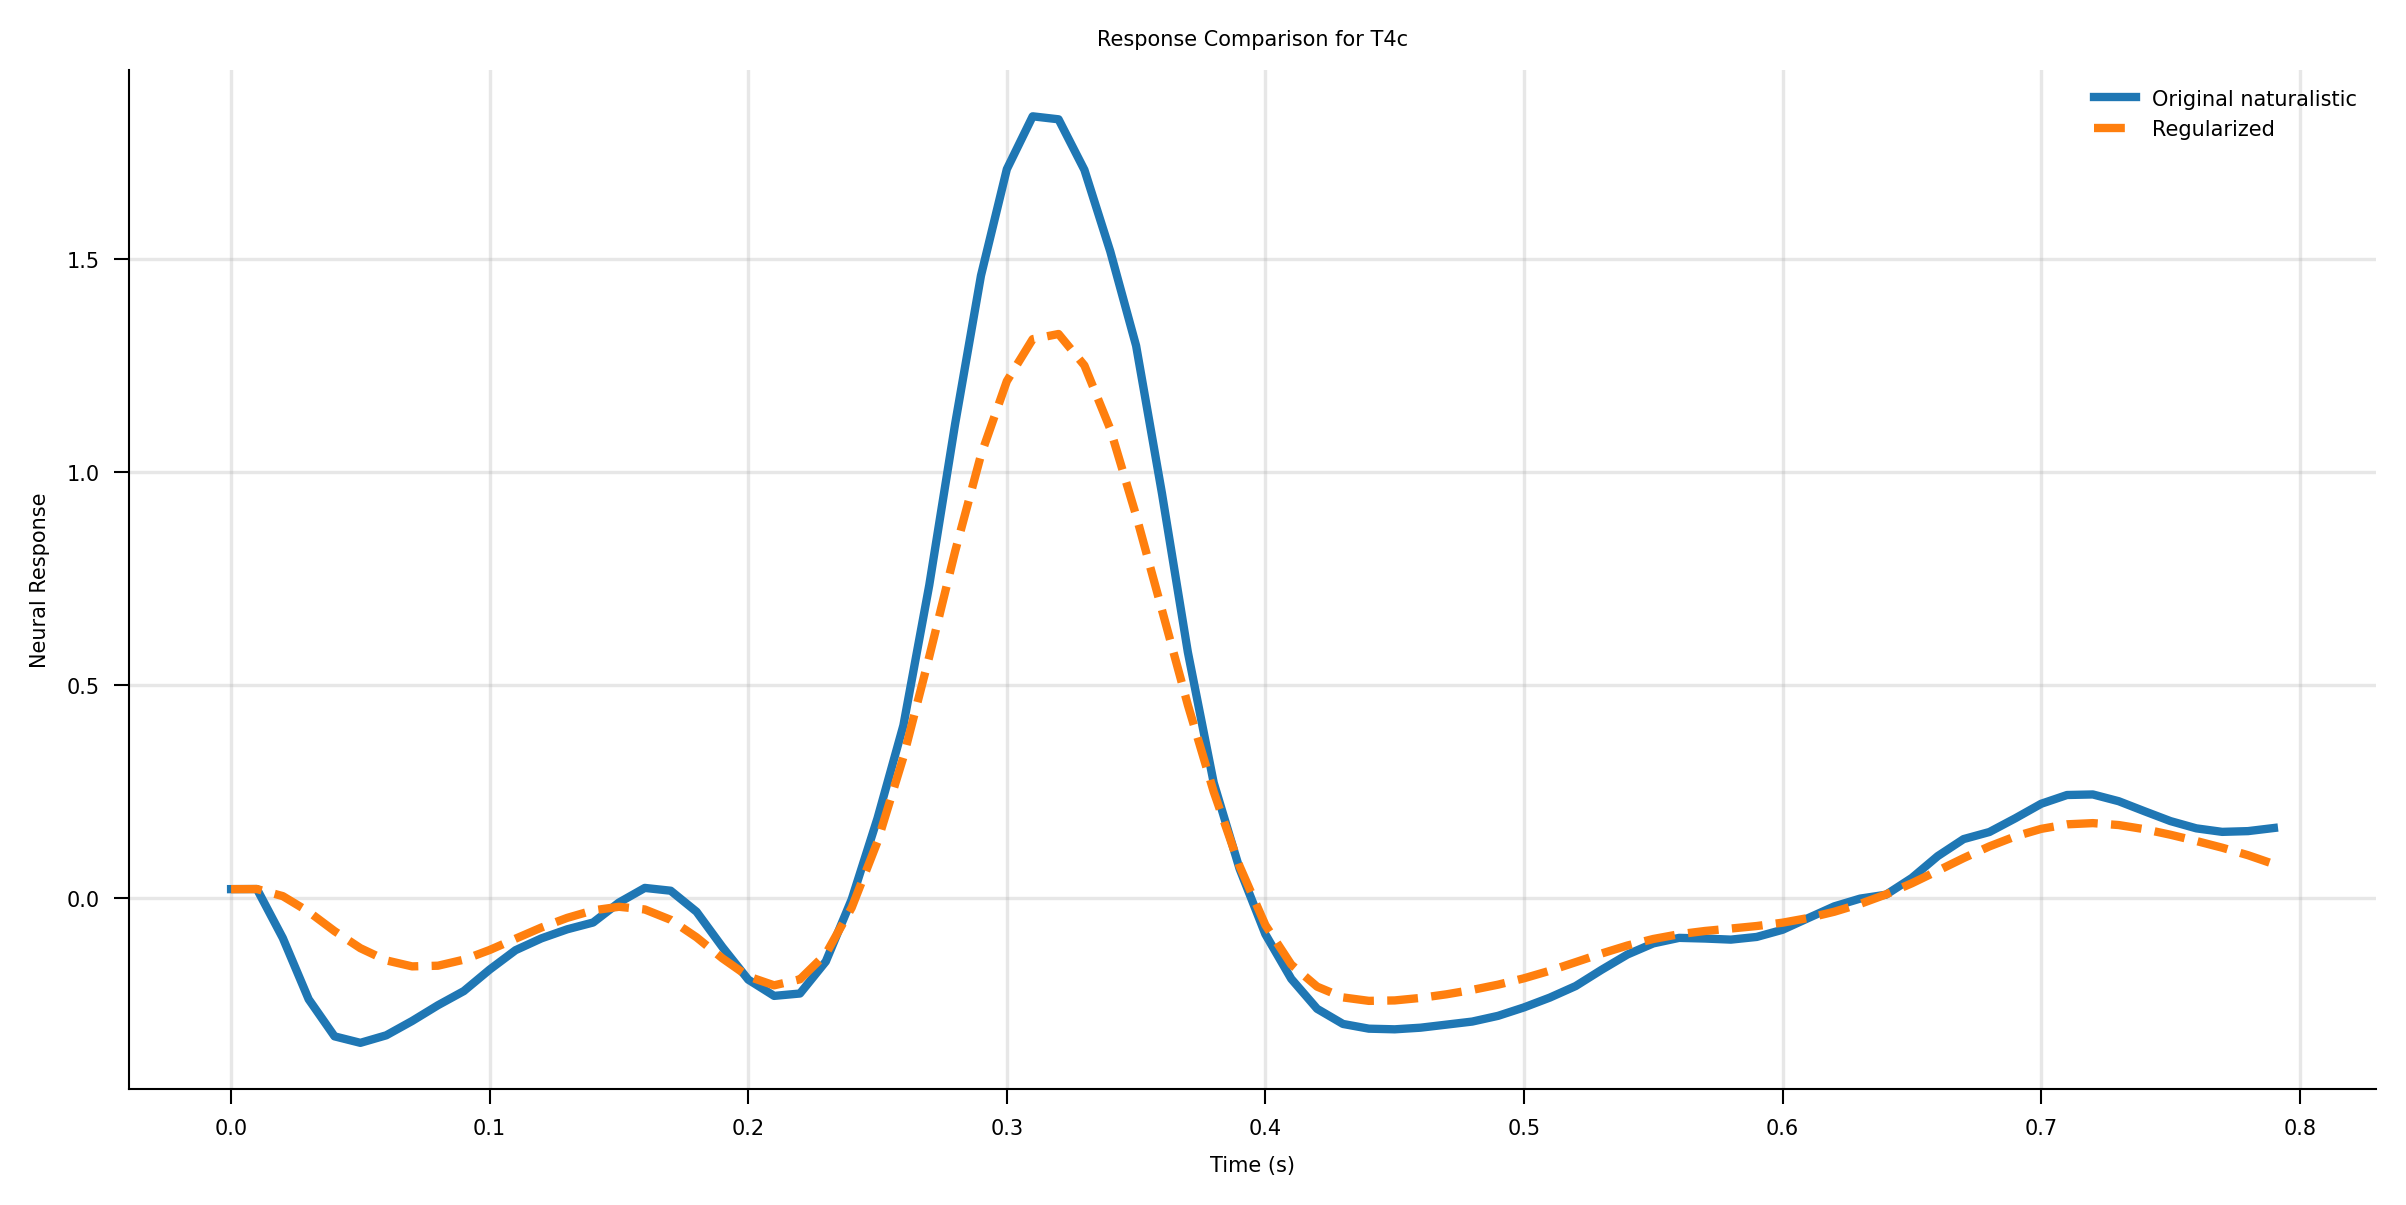

Correlation between original and regularized responses: 0.995


In [8]:
# Compare the neural responses
fig, ax = plt.subplots(figsize=(8, 4))

time = np.arange(len(optstim.central_target_response)) / 100
ax.plot(
    time, optstim.central_target_response, label="Original naturalistic", linewidth=2
)
ax.plot(
    time,
    optstim.central_predicted_response,
    label="Regularized",
    linewidth=2,
    linestyle="--",
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Neural Response")
ax.set_title(f"Response Comparison for {target_cell_type}")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between responses
correlation = np.corrcoef(
    optstim.central_target_response, optstim.central_predicted_response
)[0, 1]
print(f"Correlation between original and regularized responses: {correlation:.3f}")

### 🤔 Discussion Questions

1. How does the regularized stimulus differ from the original?
2. What does this tell us about which features are important for driving T4c responses?
3. Why might the regularized stimulus be more useful in neuroscience research?

## Part 4: Generating artificial optimal stimuli

Now let's generate an optimal stimulus completely from scratch using gradient-based optimization:

In [9]:
# Create stimulus generator
genoptstim = GenerateOptimalStimuli(network_view)

# Generate artificial optimal stimulus
print(f"Generating artificial optimal stimulus for {target_cell_type}...")
artoptstim = genoptstim.artificial_optimal_stimuli(target_cell_type, t_stim=0.8)

print("Generation complete!")

[2025-12-31 13:04:58] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2025-12-31 13:04:58] chkpt_utils:36 Recovered network state.


Generating artificial optimal stimulus for T4c...
Generation complete!


Text(0.5, 0.8, 'Artificial Optimal Stimulus for T4c')

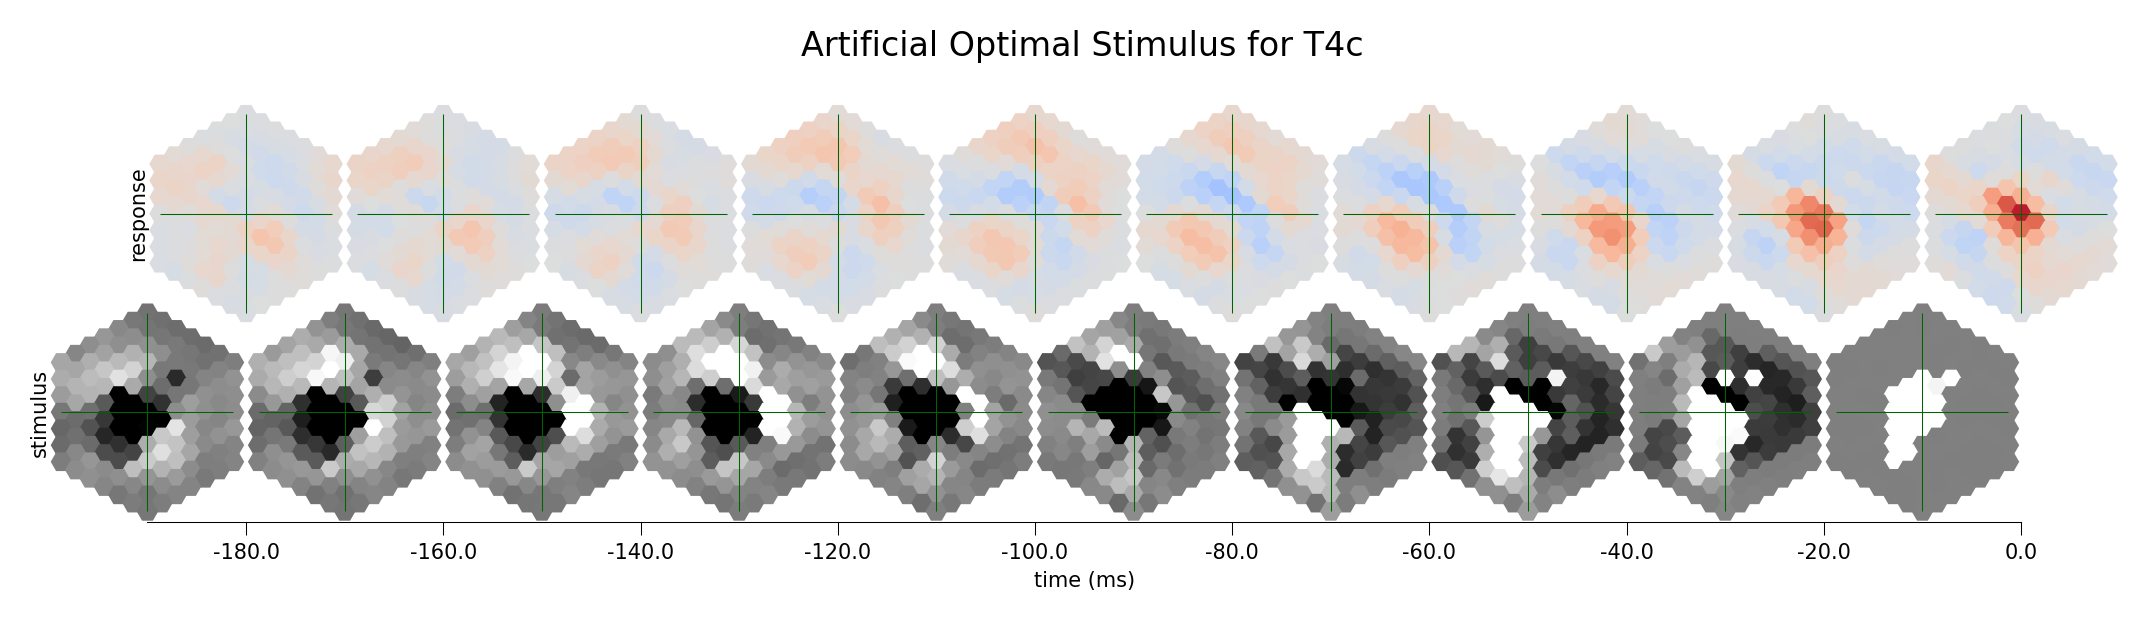

In [10]:
# Plot the artificial optimal stimulus
stim_resp_plot = plot_stim_response(
    artoptstim.stimulus,
    artoptstim.response,
    1 / 100,
    *network_view.connectome_view.get_uv(target_cell_type),
    figsize=[8, 3],
    label_peak_response=True,
)

plt.gcf().suptitle(
    f"Artificial Optimal Stimulus for {target_cell_type}", fontsize=8, y=0.8
)

## Part 5: Comparing All Three Stimulus Types

Let's compare the neural responses evoked by all three types of optimal stimuli:

In [11]:
def plot_ms_before_peak(
    response, dt, seconds_before, ax, seconds_after=0.1, **plot_kwargs
):
    """
    Plot response aligned to peak time.

    Parameters:
    - response: 1D array or 2D array (will take central column if 2D)
    - dt: time step in seconds
    - seconds_before: seconds to show before peak
    - seconds_after: seconds to show after peak (default 0.1)
    - **plot_kwargs: additional kwargs passed to plt.plot()

    Returns:
    - peak_time: original peak time in seconds
    - peak_idx: original peak index
    """
    # Handle 2D response by taking central column
    if response.ndim > 1:
        response_1d = response[:, response.shape[-1] // 2].flatten()
    else:
        response_1d = response.flatten()

    # Find peak
    argmax = np.nanargmax(response_1d)
    n_frames = len(response_1d)
    time = np.arange(n_frames) * dt
    t_argmax = time[argmax]

    # Calculate window around peak
    steps_before = int(seconds_before / dt)
    steps_after = int(seconds_after / dt)

    start_idx = max(0, argmax - steps_before)
    end_idx = min(n_frames, argmax + steps_after)

    # Extract window
    window = response_1d[start_idx:end_idx]
    window_time = np.arange(len(window)) * dt - seconds_before

    # Plot
    ax.plot(window_time, window, **plot_kwargs)

    return t_argmax, argmax

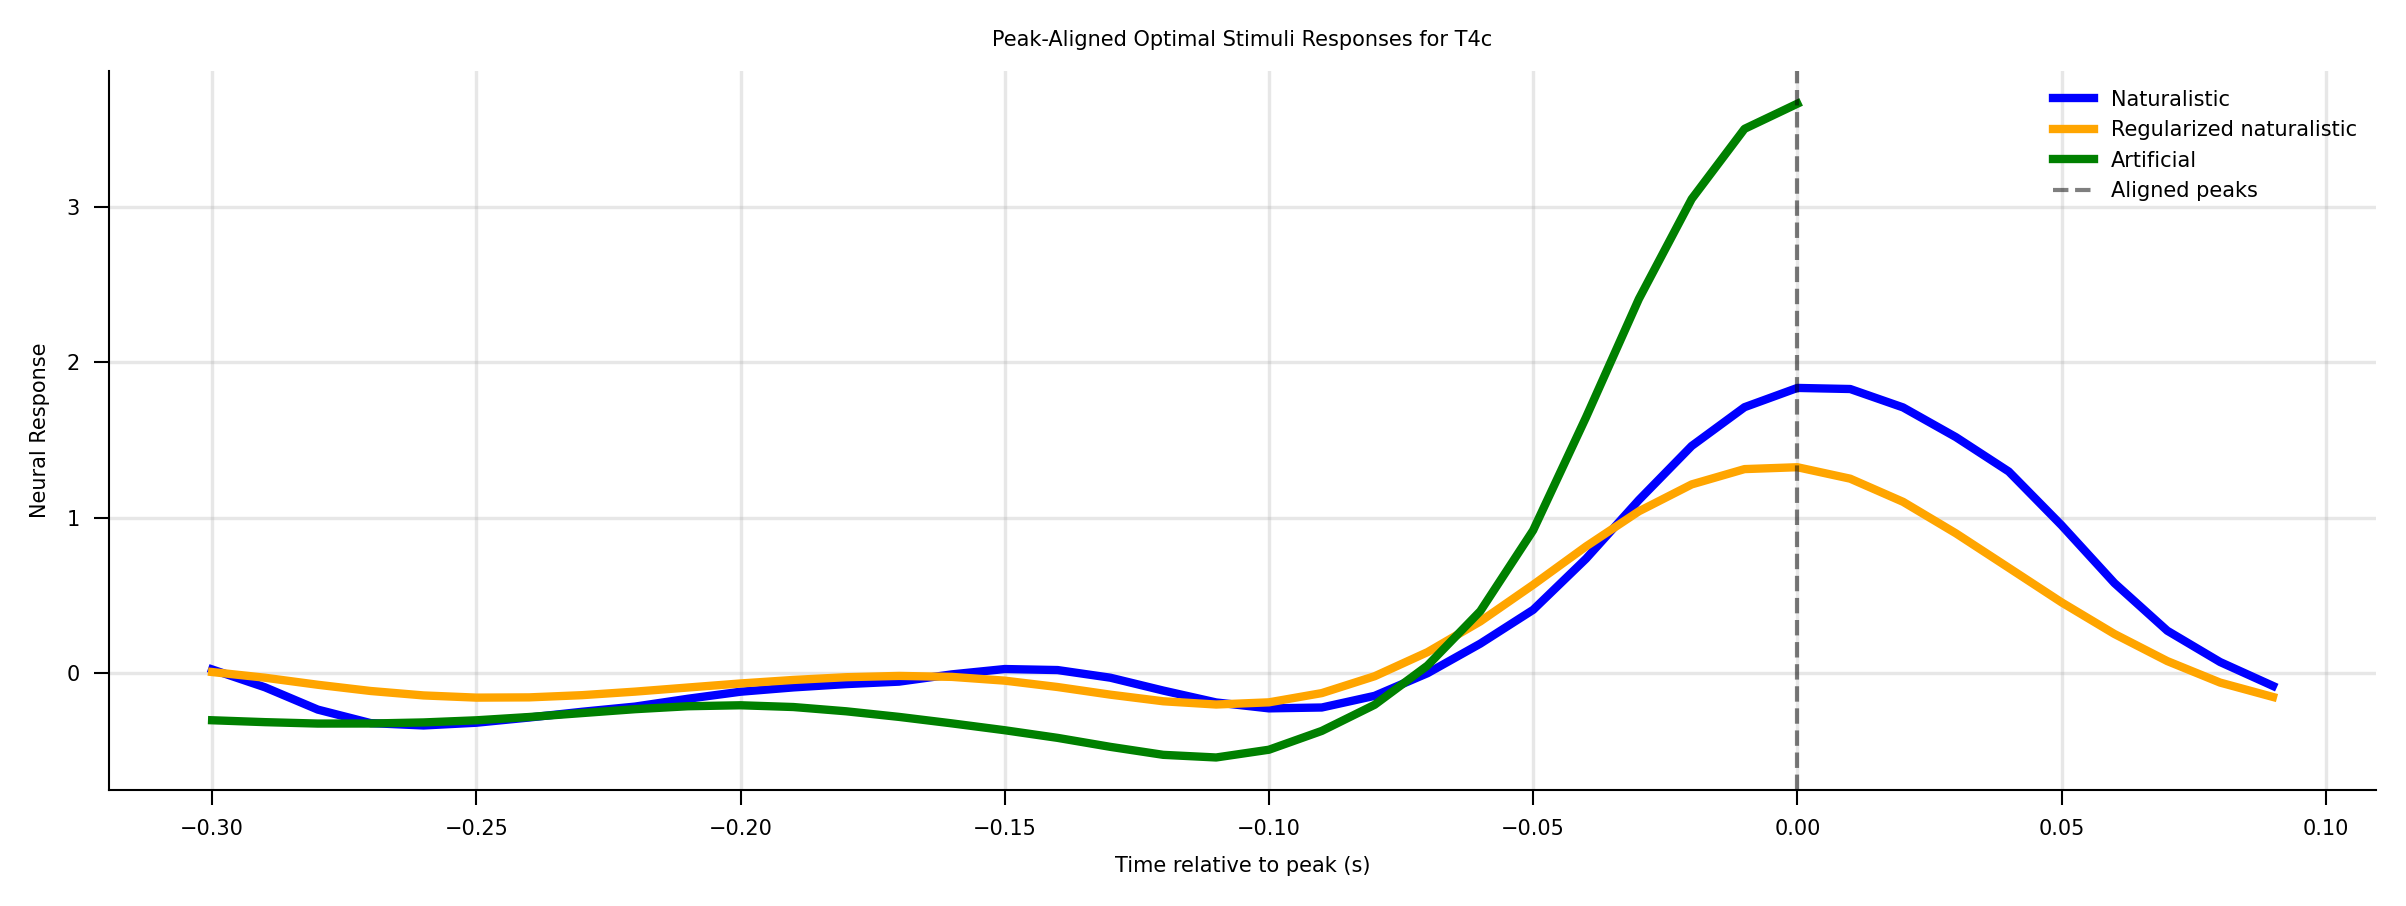

Peak values:
Naturalistic: 1.835
Regularized:  1.324
Artificial:   3.667


In [12]:
# Compare all responses aligned to peak
fig, ax = plt.subplots(figsize=(8, 3))

dt = 1 / 100  # 100 Hz sampling rate
seconds_before = 0.3  # 300 ms before peak
seconds_after = 0.1  # 100 ms after peak

# Plot each response with different styling
nat_peak_time, nat_peak_idx = plot_ms_before_peak(
    optstim.central_target_response,
    dt,
    seconds_before,
    ax,
    seconds_after=seconds_after,
    label="Naturalistic",
    linewidth=2,
    color="blue",
)

reg_peak_time, reg_peak_idx = plot_ms_before_peak(
    optstim.central_predicted_response,
    dt,
    seconds_before,
    ax,
    seconds_after=seconds_after,
    label="Regularized naturalistic",
    linewidth=2,
    color="orange",
)

artificial_response = artoptstim.response[
    :, :, artoptstim.response.shape[-1] // 2
].flatten()
art_peak_time, art_peak_idx = plot_ms_before_peak(
    artificial_response,
    dt,
    seconds_before,
    ax,
    seconds_after=seconds_after,
    label="Artificial",
    linewidth=2,
    color="green",
)

# Add vertical line at peak (t=0)
ax.axvline(x=0, color="black", linestyle="--", alpha=0.5, label="Aligned peaks")

ax.set_xlabel("Time relative to peak (s)")
ax.set_ylabel("Neural Response")
ax.set_title(f"Peak-Aligned Optimal Stimuli Responses for {target_cell_type}")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print peak information
print("Peak values:")
print(f"Naturalistic: {np.max(optstim.central_target_response.numpy()):.3f}")
print(f"Regularized:  {np.max(optstim.central_predicted_response.numpy()):.3f}")
print(f"Artificial:   {np.max(artificial_response):.3f}")

## Part 6: Exploring different cell types

Let's try this analysis with a different cell type to see how the optimal stimuli differ:

Analyzing optimal stimuli for T5c...
/groups/turaga/home/stefanidiz/miniconda3/envs/flysim_tutorials/lib/python3.11/site-packages/flyvis/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_optimal_stimulus_responses/0486fff84cdcb1f1b20f993dfac1fd0a/output.h5


Text(0.5, 0.8, 'Regularized Optimal Stimulus for T5c')

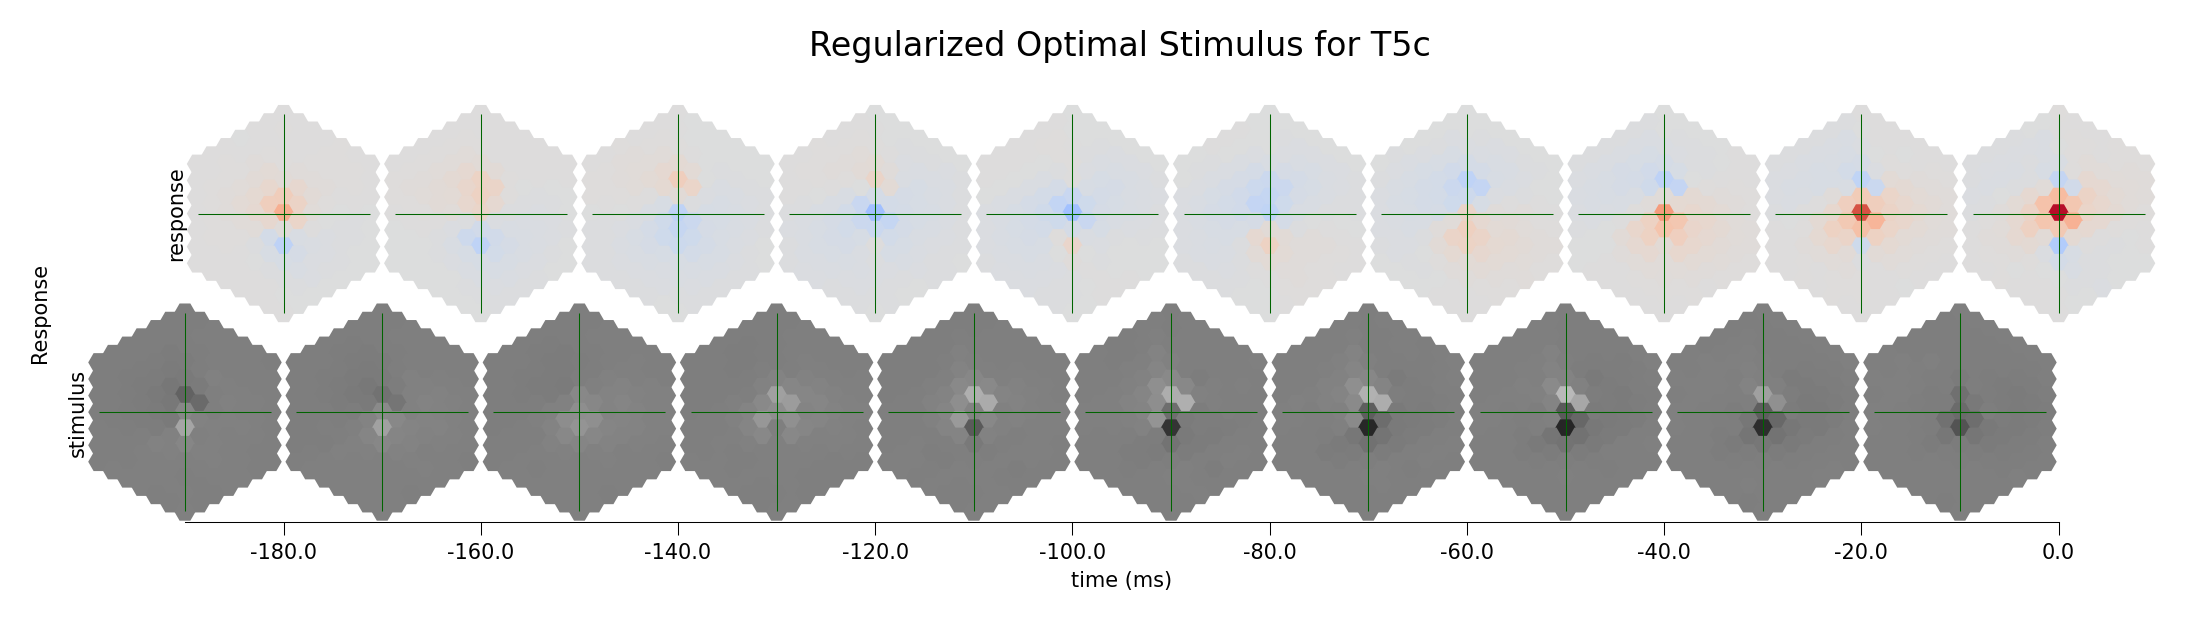

In [13]:
# Try with a different cell type
target_cell_type_2 = "T5c"  # T5c responds to OFF edges moving upward

print(f"Analyzing optimal stimuli for {target_cell_type_2}...")

# Get optimal stimulus responses for T5c
optstim_t5c = network_view.optimal_stimulus_responses(target_cell_type_2)

# Plot regularized stimulus for T5c
stim_resp_plot = plot_stim_response(
    optstim_t5c.regularized_stimulus,
    optstim_t5c.response,
    1 / 100,
    *network_view.connectome_view.get_uv(target_cell_type_2),
    figsize=[8, 3],
    ylabel="Response",
    label_peak_response=True,
)

plt.gcf().suptitle(
    f"Regularized Optimal Stimulus for {target_cell_type_2}", fontsize=8, y=0.8
)

### 🤔 Discussion Questions

1. How does the optimal stimulus for T5c differ from T4c?
2. What does this tell us about the functional differences between these cell types?
3. What are the advantages and disadvantages of each stimulus type for neuroscience research?
4. Which stimulus type (naturalistic, regularized, or artificial) gives the strongest response?
5. What would be other interesting objectives to use for the artificial stimulus design? 

## Part 7: Hands-on exercise

Now it's your turn! Choose a different cell type and analyze its optimal stimuli:

In [14]:
# Exercise: Choose your own cell type to analyze
# Available cell types: L1, L2, L3, L4, L5, Mi1, Tm3, Mi4, Mi9, CT1(M10),
#                      T4a, T4b, T4c, T4d, T5a, T5b, T5c, T5d, Tm1, Tm2, Tm4, Tm9, etc.

your_cell_type = "Mi1"  # Change this to your chosen cell type

# Your code here:
# 1. Get optimal stimulus responses for your chosen cell type
# 2. Plot the regularized optimal stimulus
# 3. Generate an artificial optimal stimulus
# 4. Compare the responses

# Hint: Follow the same pattern as above but replace the cell type

## Summary

In this tutorial, you've learned to:

1. **Load and work with neural network models** of the fly visual system.
2. **Find optimal naturalistic stimuli** from datasets of natural scenes.
3. **Create regularized stimuli** that maintain neural responses while removing unnecessary details.
4. **Generate artificial optimal stimuli** using gradient-based optimization.
5. **Compare different stimulus types** and their effectiveness.

### Key Insights

- Different cell types respond optimally to different visual features.
- Regularization can reveal the essential features driving neural responses.
- Artificial stimuli can sometimes evoke stronger responses than natural stimuli.
- These techniques are powerful tools for understanding neural computation.

## Supporting references

**General:**

Flyvis Documentation. https://turagalab.github.io/flyvis/.  
Lappalainen, J. K. et al. Connectome-constrained networks predict neural activity across the fly visual system. Nature 634, 1132–1140 (2024).